# 04 - Train DistilBERT Multi-label Classifier

## Goal

Train DistilBERT for multi-label classification on title+abstract. We'll use BCEWithLogits, monitor micro/macro F1, and tune threshold on the validation set.


## Why Multi-label Classification?

Each paper can have multiple study characteristics:
- An **RCT** is also **Human**
- A **Systematic Review** might be a **MetaAnalysis**
- Some studies combine **Animal** + **InVitro**

We use **binary cross-entropy** (BCE) for each label independently.


In [12]:
# === TODO (you code this) ===
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset


In [13]:
# === TODO (you code this) ===
# Goal: Define canonical label list (MUST match order from notebook 02).
# Hints:
# 1) 10 labels in this exact order for consistency
# 2) Store as LABELS constant and compute NUM_LABELS
# Acceptance:
# - LABELS list with 10 study-design categories
# - NUM_LABELS = 10
# - Print for verification

# Canonical label list - MUST match the order from notebook 02
# This order is critical for converting labels to binary vectors
LABELS = [
    'SystematicReview',  # 1. Systematic reviews
    'MetaAnalysis',      # 2. Meta-analyses (quantitative synthesis)
    'RCT',               # 3. Randomized Controlled Trials
    'ClinicalTrial',     # 4. Non-randomized clinical trials
    'Cohort',            # 5. Cohort studies (prospective/retrospective)
    'CaseControl',       # 6. Case-control studies
    'CaseReport',        # 7. Case reports / case series
    'InVitro',           # 8. In vitro or ex vivo laboratory studies
    'Animal',            # 9. Animal studies
    'Human'              # 10. Human subjects (not mutually exclusive)
]

NUM_LABELS = len(LABELS)

# Verification
print(f"✅ Canonical label list defined:")
print(f"   Number of labels: {NUM_LABELS}")
print(f"   Labels: {LABELS}")
print(f"\n📋 Label order (for binary vector encoding):")
for i, label in enumerate(LABELS):
    print(f"   Index {i}: {label}")


✅ Canonical label list defined:
   Number of labels: 10
   Labels: ['SystematicReview', 'MetaAnalysis', 'RCT', 'ClinicalTrial', 'Cohort', 'CaseControl', 'CaseReport', 'InVitro', 'Animal', 'Human']

📋 Label order (for binary vector encoding):
   Index 0: SystematicReview
   Index 1: MetaAnalysis
   Index 2: RCT
   Index 3: ClinicalTrial
   Index 4: Cohort
   Index 5: CaseControl
   Index 6: CaseReport
   Index 7: InVitro
   Index 8: Animal
   Index 9: Human


## Load Splits & Build HF Datasets


In [14]:
# === TODO (you code this) ===
# Goal: Load train/val/test splits and create 'text' column.
# Hints:
# 1) Load three parquet files from ../data/processed
# 2) Concatenate title + ' ' + abstract into 'text' column
# 3) Truncate to reasonable length (e.g., 2000 chars)
# Acceptance:
# - train_df, val_df, test_df loaded
# - Each has 'text' column
# - Print counts
from pathlib import Path
import pandas as pd

# TODO: load splits and create text column
processed_data_path = Path('../data/processed')
train_df = pd.read_parquet(processed_data_path / 'train.parquet')
val_df = pd.read_parquet(processed_data_path / 'val.parquet')
test_df = pd.read_parquet(processed_data_path / 'test.parquet')

train_df['text'] = train_df['title'] + ' ' + train_df['abstract']
val_df['text'] = val_df['title'] + ' ' + val_df['abstract']
test_df['text'] = test_df['title'] + ' ' + test_df['abstract']

train_df['text'] = train_df['text'].str[:2000]
val_df['text'] = val_df['text'].str[:2000]
test_df['text'] = test_df['text'].str[:2000]

def acceptance_criteria():
    assert train_df['text'].notna().all(), "All texts should be non-null"
    assert val_df['text'].notna().all(), "All texts should be non-null"
    assert test_df['text'].notna().all(), "All texts should be non-null"
    assert train_df['text'].str.len().max() <= 2000, "Texts should be truncated to 2000 characters"
    assert val_df['text'].str.len().max() <= 2000, "Texts should be truncated to 2000 characters"
    assert test_df['text'].str.len().max() <= 2000, "Texts should be truncated to 2000 characters"
    assert train_df['text'].str.len().min() > 0, "Texts should not be empty"
    assert val_df['text'].str.len().min() > 0, "Texts should not be empty"
    assert test_df['text'].str.len().min() > 0, "Texts should not be empty"
    return "Acceptance criteria met"

print(acceptance_criteria())







Acceptance criteria met


## Binarize Labels

Convert list of labels → multi-hot binary vector.


In [15]:
# === TODO (you code this) ===
# Goal: Convert labels lists to multi-hot binary vectors.
# Hints:
# 1) Create zero vector of length NUM_LABELS
# 2) Set index to 1.0 for each label in LABELS
# 3) Apply to all three DataFrames
# Acceptance:
# - Function binarize_labels(labels_list) -> list of floats
# - New column 'label_vec' in all DataFrames
# - Vector length = NUM_LABELS

def binarize_labels(labels_list):
    """Convert list of labels to multi-hot vector."""
    # TODO
    zero_vector = [0.0] * NUM_LABELS
    for label in labels_list:
        if label in LABELS:
            zero_vector[LABELS.index(label)] = 1.0
    return zero_vector

train_df['label_vec'] = train_df['labels'].apply(binarize_labels)
val_df['label_vec'] = val_df['labels'].apply(binarize_labels)
test_df['label_vec'] = test_df['labels'].apply(binarize_labels)

print(train_df[['text', "labels", 'label_vec']].head())
print(train_df["label_vec"].value_counts())





                                                   text   labels  \
1347  Stability of Class II Malocclusion Treatment w...  [Human]   
1348  The Dental Aesthetic Index and Its Association...  [Human]   
1349  Aboriginal Health Workers Promoting Oral Healt...  [Human]   
1350  Sleep Bruxism in Children: Etiology, Diagnosis...  [Human]   
1351  Orthodontic Extrusion vs. Surgical Extrusion t...  [Human]   

                                              label_vec  
1347  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1348  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1349  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1350  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1351  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
label_vec
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]    15441
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]     2636
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]     1810
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]   

In [16]:
# === TODO (you code this) ===
# Goal: Create HuggingFace Dataset objects.
# Hints:
# 1) Use Dataset.from_pandas() with just 'text' and 'label_vec' columns
# 2) Create for all three splits
# Acceptance:
# - train_dataset, val_dataset, test_dataset created
# - Each contains 'text' and 'label_vec' fields
from datasets import Dataset

# TODO: convert to HF Dataset objects
def convert_to_hf_dataset(df):
    return Dataset.from_pandas(df[['text', 'label_vec']])

train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

# Test
print(train_dataset[0])
print(val_dataset[0])
print(test_dataset[0])




{'text': "Stability of Class II Malocclusion Treatment with the Austro Repositioner Followed by Fixed Appliances in Brachyfacial Patients. One of the goals of functional-appliance devices is to modify the vertical growth pattern, solving several kinds of malocclusion. This study aimed to evaluate Class II malocclusion treatment's stability with Austro Repositioner, followed by fixed appliances, and assess its capacity to modify vertical dimensions in brachyfacial patients. A test group of 30 patients (16 boys and 14 girls, mean 11.9 years old) with Class II malocclusion due to mandibular retrognathism and brachyfacial pattern treated with Austro Repositioner and fixed appliance were compared to a matched untreated Class II control group of 30 patients (17 boys and 13 girls, mean age 11.7 years old). Lateral cephalograms were taken at T1 (initial records), T2 (end of treatment), and T3 (one year after treatment). Statistical comparisons were performed with a paired-sample  t -test and t

## Tokenizer & Encoding


In [17]:
# === TODO (you code this) ===
# Goal: Tokenize datasets and prepare for training.
# Hints:
# 1) Load tokenizer for 'distilbert-base-uncased'
# 2) Create tokenize function with max_length=512, truncation, padding
# 3) Map tokenize function to all datasets (batched=True)
# 4) Rename 'label_vec' → 'labels', set format to torch
# Acceptance:
# - tokenizer loaded
# - All datasets have input_ids, attention_mask, labels
# - Format set to 'torch'

# TODO: tokenize and format datasets
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_and_format(dataset):
    return dataset.map(lambda x: tokenizer(x['text'], max_length=512, truncation=True, padding='max_length'), batched=True)

train_dataset = tokenize_and_format(train_dataset)
val_dataset = tokenize_and_format(val_dataset)
test_dataset = tokenize_and_format(test_dataset)

# Rename 'label_vec' → 'labels', set format to torch
train_dataset = train_dataset.rename_column('label_vec', 'labels')
val_dataset = val_dataset.rename_column('label_vec', 'labels')
test_dataset = test_dataset.rename_column('label_vec', 'labels')

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Test
print(train_dataset[0])
print(val_dataset[0])
print(test_dataset[0])

print(train_dataset.format)
print(val_dataset.format)
print(test_dataset.format)

# Acceptance
# Acceptance
assert train_dataset.format is not None and train_dataset.format['type'] == 'torch'
assert val_dataset.format is not None and val_dataset.format['type'] == 'torch'
assert test_dataset.format is not None and test_dataset.format['type'] == 'torch'
assert 'labels' in train_dataset.column_names
assert 'labels' in val_dataset.column_names
assert 'labels' in val_dataset.column_names
assert train_dataset.num_rows == len(train_df)
assert val_dataset.num_rows == len(val_df)
assert test_dataset.num_rows == len(test_df)

# Check formatted columns (the ones that will be returned)
assert train_dataset.format['columns'] == ['input_ids', 'attention_mask', 'labels']
assert val_dataset.format['columns'] == ['input_ids', 'attention_mask', 'labels']
assert test_dataset.format['columns'] == ['input_ids', 'attention_mask', 'labels']

# Verify the actual data structure when accessing
sample = train_dataset[0]
assert set(sample.keys()) == {'input_ids', 'attention_mask', 'labels'}
assert len(sample['labels']) == NUM_LABELS  # Should be 10




Map:   0%|          | 0/29926 [00:00<?, ? examples/s]

Map:   0%|          | 0/16057 [00:00<?, ? examples/s]

Map:   0%|          | 0/18666 [00:00<?, ? examples/s]

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), 'input_ids': tensor([  101,  9211,  1997,  2465,  2462, 15451, 10085, 20464, 14499,  3949,
         2007,  1996, 16951, 16360, 19234,  2121,  2628,  2011,  4964, 22449,
         1999, 11655, 11714,  7011, 13247,  5022,  1012,  2028,  1997,  1996,
         3289,  1997,  8360,  1011, 10439, 15204,  3401,  5733,  2003,  2000,
        19933,  1996,  7471,  3930,  5418,  1010, 13729,  2195,  7957,  1997,
        15451, 10085, 20464, 14499,  1012,  2023,  2817,  6461,  2000, 16157,
         2465,  2462, 15451, 10085, 20464, 14499,  3949,  1005,  1055,  9211,
         2007, 16951, 16360, 19234,  2121,  1010,  2628,  2011,  4964, 22449,
         1010,  1998, 14358,  2049,  3977,  2000, 19933,  7471,  9646,  1999,
        11655, 11714,  7011, 13247,  5022,  1012,  1037,  3231,  2177,  1997,
         2382,  5022,  1006,  2385,  3337,  1998,  2403,  3057,  1010,  2812,
         2340,  1012,  1023,  2086,  2214,  1007,  2007,  2465,  246

## Model Initialization


In [18]:
# === TODO (you code this) ===
# Goal: Initialize DistilBERT for multi-label classification.
# Hints:
# 1) Use AutoModelForSequenceClassification.from_pretrained
# 2) Set num_labels=NUM_LABELS, problem_type='multi_label_classification'
# Acceptance:
# - model initialized from 'distilbert-base-uncased'
# - Configured for multi-label (uses BCEWithLogits loss)

# TODO: initialize model
# Use AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=NUM_LABELS, problem_type='multi_label_classification')

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Metrics Function


In [19]:
# === TODO (you code this) ===
# Goal: Define metrics function for Trainer.
# Hints:
# 1) Apply sigmoid to logits, threshold at 0.5
# 2) Compute micro/macro precision, recall, F1 using sklearn
# 3) Return dict with 6 metrics
# Acceptance:
# - Function compute_metrics(eval_pred) -> dict
# - Returns precision/recall/f1 for both micro and macro
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torch

def compute_metrics(eval_pred):
    """Compute evaluation metrics for multi-label classification."""
    logits, labels = eval_pred
    
    # Convert to numpy if they're tensors
    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Apply sigmoid to get probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.from_numpy(logits)).numpy()
    
    # Threshold at 0.5 to get binary predictions
    y_pred = (probs >= 0.5).astype(int)
    y_true = labels.astype(int)
    
    # Compute metrics
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return {
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }


## Training Arguments & Trainer


In [20]:
# === TODO (you code this) ===
# Goal: Configure training parameters.
# Hints:
# 1) Set output_dir, eval_strategy, save_strategy, learning_rate
# 2) batch_size=8, epochs=3-4, warmup_ratio=0.1
# 3) load_best_model_at_end=True, metric_for_best_model='f1_micro'
# Acceptance:
# - TrainingArguments object configured
# - Will save to ../artifacts/model/checkpoints
# - Evaluates each epoch and keeps best
# TODO: create training_args
# Create artifacts directory if it doesn't exist
# Fix tokenizers parallelism warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

os.makedirs('../artifacts/model/checkpoints', exist_ok=True)
os.makedirs('../artifacts/model/logs', exist_ok=True)

training_args = TrainingArguments(
    output_dir='../artifacts/model/checkpoints',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_micro',
    save_total_limit=1,
    logging_dir='../artifacts/model/logs',
    logging_strategy='epoch',
    warmup_ratio=0.1,
    seed=42
)






In [22]:
# === TODO (you code this) ===
# Goal: Train model and save best checkpoint.
# Hints:
# 1) Create Trainer with model, args, datasets, compute_metrics
# 2) Call trainer.train()
# 3) Save best model and tokenizer to ../artifacts/model/best
# Acceptance:
# - Training completes successfully
# - Best model saved based on micro-F1
# - Both model and tokenizer saved

# Create Trainer (Trainer handles accelerate internally, no need for Accelerator context)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Run training
print("🚀 Starting training...")
trainer.train()

# Save best model and tokenizer
print("💾 Saving best model...")
trainer.save_model('../artifacts/model/best')
tokenizer.save_pretrained('../artifacts/model/best')
print("✅ Training complete! Best model saved to ../artifacts/model/best")

🚀 Starting training...


Epoch,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro
1,0.067500,0.059728,0.909802,0.943889,0.926532,0.686910,0.744172,0.713848
2,0.059300,0.058338,0.910932,0.947179,0.928702,0.758201,0.768775,0.754481
3,0.047000,0.059691,0.909662,0.946258,0.927599,0.759831,0.789409,0.770885


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


💾 Saving best model...
✅ Training complete! Best model saved to ../artifacts/model/best


📊 Training metrics plot saved to ../image/training_metrics.png


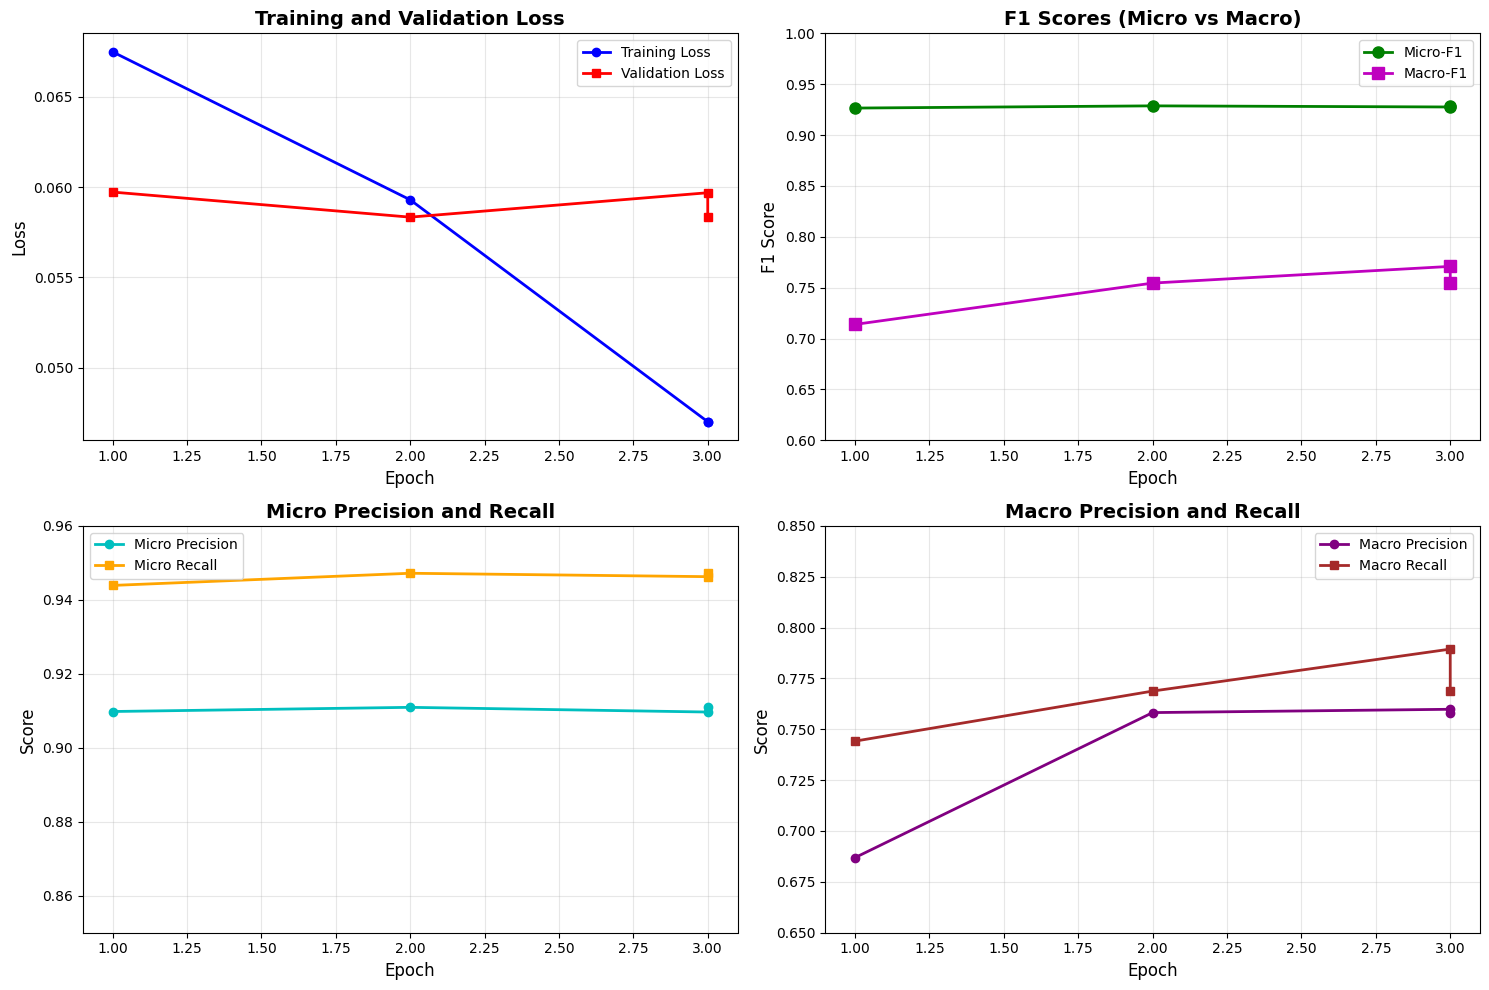


Training Summary
Epoch    Train Loss   Val Loss     Micro-F1     Macro-F1    
------------------------------------------------------------
1.0      0.0675       0.0597       0.9265       0.7138      
2.0      0.0593       0.0583       0.9287       0.7545      
3.0      0.0470       0.0597       0.9276       0.7709      
3.0      0.0470       0.0583       0.9287       0.7545      


In [ ]:
# Visualize training results
from matplotlib import pyplot as plt
import os

# Visualize training results
import matplotlib.pyplot as plt
import numpy as np

# Access training history from trainer state
history = trainer.state.log_history

# Extract metrics for each epoch
train_logs = []
eval_logs = []

# Separate training and evaluation logs
for entry in history:
    if 'loss' in entry and 'eval_loss' not in entry:
        train_logs.append(entry)
    elif 'eval_loss' in entry:
        eval_logs.append(entry)

# Extract metrics from evaluation logs (these are aligned by epoch)
epochs = [log['epoch'] for log in eval_logs]
val_losses = [log['eval_loss'] for log in eval_logs]
micro_f1 = [log['eval_f1_micro'] for log in eval_logs]
macro_f1 = [log['eval_f1_macro'] for log in eval_logs]
micro_precision = [log['eval_precision_micro'] for log in eval_logs]
micro_recall = [log['eval_recall_micro'] for log in eval_logs]
macro_precision = [log['eval_precision_macro'] for log in eval_logs]
macro_recall = [log['eval_recall_macro'] for log in eval_logs]

# Extract training losses (align with evaluation epochs)
train_losses = [log['loss'] for log in train_logs if 'epoch' in log]

# Ensure train_losses matches the length of eval metrics
# If there's a mismatch, take the last N training losses to match eval logs
if len(train_losses) > len(epochs):
    train_losses = train_losses[-len(epochs):]
elif len(train_losses) < len(epochs):
    # Pad with the last available training loss if needed
    train_losses = train_losses + [train_losses[-1]] * (len(epochs) - len(train_losses))

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss curves
axes[0, 0].plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: F1 Scores
axes[0, 1].plot(epochs, micro_f1, 'g-o', label='Micro-F1', linewidth=2, markersize=8)
axes[0, 1].plot(epochs, macro_f1, 'm-s', label='Macro-F1', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_title('F1 Scores (Micro vs Macro)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0.6, 1.0])

# Plot 3: Precision and Recall (Micro)
axes[1, 0].plot(epochs, micro_precision, 'c-o', label='Micro Precision', linewidth=2)
axes[1, 0].plot(epochs, micro_recall, 'orange', marker='s', label='Micro Recall', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Micro Precision and Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0.85, 0.96])

# Plot 4: Precision and Recall (Macro)
axes[1, 1].plot(epochs, macro_precision, 'purple', marker='o', label='Macro Precision', linewidth=2)
axes[1, 1].plot(epochs, macro_recall, 'brown', marker='s', label='Macro Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Macro Precision and Recall', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0.65, 0.85])

plt.tight_layout()

# Create images directory if it doesn't exist
os.makedirs('../image', exist_ok=True)

# Save the figure
output_path = '../image/training_metrics.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"📊 Training metrics plot saved to {output_path}")

plt.show()

# Print summary table
print("\n" + "="*60)
print("Training Summary")
print("="*60)
print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Micro-F1':<12} {'Macro-F1':<12}")
print("-"*60)
for i, epoch in enumerate(epochs):
    print(f"{epoch:<8.1f} {train_losses[i]:<12.4f} {val_losses[i]:<12.4f} {micro_f1[i]:<12.4f} {macro_f1[i]:<12.4f}")
print("="*60)

## Recommendations

- If rare labels underperform, try **class weights** or **focal loss** (stretch goal)
- Track **ROC/PR curves** on val to tune per-label thresholds later
- Monitor for **overfitting:** val metrics should not degrade while train improves

## 🧘 Reflection Log

**What did you learn in this session?**
- 

**What challenges did you encounter?**
- 

**How will this improve Periospot AI?**
- 
